# MLB Season Win Prediction Model

**Objective:**

* Develop a machine learning model to predict the number of wins a Major League Baseball (MLB) team will achieve in a season, based on their aggregated player statistics.
* Apply the trained model to 2024 data to forecast the outcomes of the 2024 regular season.

**Methodology:**

1.  **Data Preparation:**
    * Load and preprocess team statistics data, including hitting and pitching metrics, and relevant league and division information.
    * Calculate relative team performance metrics by comparing team statistics to their division, league, and MLB averages.
2.  **Model Selection and Training:**
    * Utilize a Random Forest Regressor model, or XGBoost regressor, to predict team wins.
    * Employ techniques such as hyperparameter tuning (GridSearchCV) and feature selection to optimize model performance.
    * Implement train/test split to evaluate the model's performance.
3.  **Model Evaluation:**
    * Assess model accuracy using Root Mean Squared Error (RMSE) on the test dataset.
    * Use permutation feature importance to analyze the influence of different statistics on the model's predictions.
4.  **Prediction and Analysis:**
    * Apply the trained model to 2024 team statistics data to generate win predictions.
    * Adjust the predicted wins to match the total expected wins in a season.
    * Use the predictions to determine division winners and wild card teams.
5.  **Playoff Picture Creation:**
    * Create a class to take in a dataframe with a prediction column, and then determine division winners and wild card teams.

**Key Features:**

* Relative team performance metrics (compared to division, league, and MLB averages).
* Hyperparameter tuning to optimize model performance.
* Feature importance analysis to understand key predictors.
* Adjusted predictions to reflect the total expected wins in a season.
* Playoff picture class to determine division winners and wild card teams.

**Note:** The code below implements the data preprocessing, model training, prediction, and analysis steps described above.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split as tts, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error

import xgboost as xgb

# Objective: 
### &emsp;-Make a model that predicts the amount of wins a team will earn, based on their aggregated player statistics, 
### &emsp;-Apply the model to 2024 data to predict the outcome of the 2024 regular season.

In [4]:
class leagueStats:
    def __init__(self,df,features):
        self.df=df
        self.aggregates=self.features_dict(features)#dictionary that holds the columns as the key and the aggregate function
        #that should be applied as the value.
        self.features=features #The statistics for which we wish to calculate the difference between the league, division,mlb.


    def features_dict(self,F):
        """Returns a dictionary that is designed to be passed to the agg function, i.e {col_name:agg_func}."""
        D={}
        for i in F:
            D[i]='mean'
        return D

    def aggregatedStats(self,row,which='Division'):
        L=[]
        if which=='Division':
            df=self.df[(self.df['Year']==row['Year'])&(self.df['LEAGUE']==row['LEAGUE'])&(self.df['DIVISION']==row['DIVISION'])&
                       (self.df['CODE']!=row['CODE'])]
        elif which=='League':
            df = self.df[(self.df['Year'] == row['Year']) & (self.df['LEAGUE'] == row['LEAGUE'])&(self.df['CODE']!=row['CODE'])]
        else:
            df=self.df[(self.df['Year'] == row['Year']) &(self.df['CODE']!=row['CODE'])]
        for item in self.features:
            av=df[item].mean()
            L.append(row[item]-av)
        return pd.Series(L)
    def applyAgg(self):
        """Returns a dataFrame that includes columns for the teams stats relative to the teams league and division, as
        well as the entire mlb."""
        self.df[['DivDiff_'+item for item in self.features]]=self.df.apply(self.aggregatedStats ,axis=1)
        self.df[['LeagueDiff_'+item for item in self.features]]=self.df.apply(self.aggregatedStats,which='League',axis=1)
        self.df[['mlbDiff_'+item for item in self.features]]=self.df.apply(self.aggregatedStats, which='MLB',axis=1)
        return self.df

#### Read in the TeamWins csv and add Features
- The csv contains the team statistics and wins. Apply the leagueStats method to add features that represent each teams statistics relative to averages for their league and division, as well as the entire mlb.**

In [6]:
data=pd.read_csv("data/TeamWins_UpdatedVersion.csv") #Data contains teams year stats with the amount of wins for each season
base_features=['AVG','OBP','SLG','HR','BB','BB_pitch','SO_pitch','WHIP_pitch','AVG_pitch','ERA_pitch','SB'] #These are the features for which
#to build the model.
data=leagueStats(data,base_features).applyAgg()  #Adds columns to the dataframe which are the differences between
#the teams statistics and those of their diviison/league.  Also adds columns for the differences between the team stats and
#the entire MLB.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 76 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             834 non-null    int64  
 1   TEAM                   834 non-null    object 
 2   LEAGUE                 834 non-null    object 
 3   G                      834 non-null    int64  
 4   AB                     834 non-null    int64  
 5   R                      834 non-null    int64  
 6   H                      834 non-null    int64  
 7   2B                     834 non-null    int64  
 8   3B                     834 non-null    int64  
 9   HR                     834 non-null    int64  
 10  RBI                    834 non-null    int64  
 11  BB                     834 non-null    int64  
 12  SO                     834 non-null    int64  
 13  SB                     834 non-null    int64  
 14  CS                     834 non-null    int64  
 15  AVG   

In [7]:
class playoffPicture:
    def __init__(self,df):
        self.df=df
        self.divisions=[]
        divisions = self.df['DIVISION'].unique()
        self.leagues = self.df['LEAGUE'].unique()
        for item in self.leagues:
            for elem in divisions:
                self.divisions.append((item, elem))
        self.division_winners=[]
        self.divWinFrames=self.divisionWinners()
        self.wildcards=self.getWildcard()
        

    def  Print(self):
        for item in self.divWinFrames:
            print(f"Division {item[0]} {item[1]}\n{item[2].to_markdown()}")
        print("\t\t\t\t\tWildcards")
        for item in self.wildcards:
            print(f"League {item[0]}\n\t{item[1].to_markdown()}")



    def divisionWinners(self):
        dataFrames=[]
        for item in self.divisions:
            df=self.df[(self.df['LEAGUE']==item[0])&(self.df['DIVISION']==item[1])]
            df=df.sort_values(by='Prediction',ascending=False)
            self.division_winners.append(df['CODE'].head().values[0])
            df=df[['CODE','Prediction']]
            df=df.rename(columns={'CODE':'Team','Prediction':'Wins'})
            dataFrames.append((item[0],item[1],df))
        return dataFrames
    def getWildcard(self):
        wildcards=[]
        for league in self.leagues:
            df=self.df[self.df['LEAGUE']==league]
            df=df.sort_values(by='Prediction',ascending=False)
            df=df[~df['CODE'].isin(self.division_winners)]
            df = df[['CODE', 'Prediction']]
            df = df.rename(columns={'CODE': 'Team', 'Prediction': 'Wins'})
            wildcards.append((league,df.head(3)))
        return wildcards
class randomForrests:
    def __init__(self,df,features):
        self.df=df
        """Add the difference metrics to the list of features.  These are metrics for the difference between the stats
        of the team and those of their division/league as well as the entire mlb."""
        self.features=features+['DivDiff_'+item for item in features]+['LeagueDiff_'+item for item in features]+['mlbDiff_'+item for item in features]
        self.regressor = RandomForestRegressor(n_estimators=250, random_state=0, min_samples_split=5)
        np.random.seed(458)
        self.train,self.test=tts(self.df, test_size=0.3, random_state=42)
        self.X_train=self.train[self.features]
        self.y_train=self.train['WINS']
        self.X_test=self.test[self.features]
        self.y_test=self.test['WINS']
        self.model=self.Model()


    def getParams(self):
        param_grid = {
            'n_estimators': [25, 50, 100, 150,200],
            'max_features': ['sqrt', 'log2', None],
            'max_depth': [3, 6, 9,12],
            'max_leaf_nodes': [3, 6, 9,12],
            'min_samples_split':[3,6,9,12]
        }

        grid_search = GridSearchCV(RandomForestRegressor(),
                                   param_grid=param_grid)
        grid_search.fit(self.X_train, self.y_train)
        print(grid_search.best_estimator_)
    def Model(self):
        """After tuning, I could not do better than the default parameters with 250 trees"""
        regressor = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=200,max_depth=7))
        regressor.fit(self.X_train,self.y_train)
        return regressor
    def getError(self):
        """Returns the Root Mean Squared Error"""
        self.test['pred']=self.model.predict(self.X_test)
        return self.RMSE(self.test['WINS'],self.test['pred'])
    def RMSE(self,y,y_hat):
        return np.sqrt(sum((y-y_hat)**2)/len(y))
    def feature_selection(self):
        """Prints the most important features"""
        sel = SelectFromModel(RandomForestRegressor(n_estimators=200,max_depth=7, random_state=0, min_samples_split=6,max_leaf_nodes=14,min_samples_leaf=5))
        sel.fit(self.X_train, self.y_train)
        print(sel.get_support())
        selected_feat = self.X_train.columns[(sel.get_support())]
        print(selected_feat)
    def makePreds(self,df):
        """Returns a DataFrame with the predictions(amount of wins for each team).  The wins are adjusted to
        Account for the fact that there should be 2430 wins in a season."""
        X=df[self.features]
        df['Prediction']=self.model.predict(X)
        return self.CorrectWins(df)
    def CorrectWins(self,df):
        """Returns the amount of wins proportional to the total wins of all teams but in an amount that makes the total
        Amount of wins equal to the expected amount of wins for a season 2430."""
        predicted_total=df['Prediction'].sum()
        df['Prediction']=round((df['Prediction']/predicted_total)*(162*30/2))
        return df
def do_permutation_feature_importance(model,X_test,y_test):
    # Perform permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=20, random_state=42)
    
    # Create a dataframe of feature importances
    feature_importance = pd.DataFrame({
        'feature': X_test.columns,
        'importance': result.importances_mean,
        'std': result.importances_std
    }).sort_values('importance', ascending=False)
    
    # Print feature importances
    print("\nPermutation Feature Importance:")
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance['feature'], feature_importance['importance'])
    plt.errorbar(feature_importance['feature'], feature_importance['importance'], 
                 yerr=feature_importance['std'], fmt='none', color='black')
    plt.title('Permutation Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    return feature_importance


# Random Forest Model and Feature Importance

Baseline Random Forest RMSE 4.995405644500447

Permutation Feature Importance:


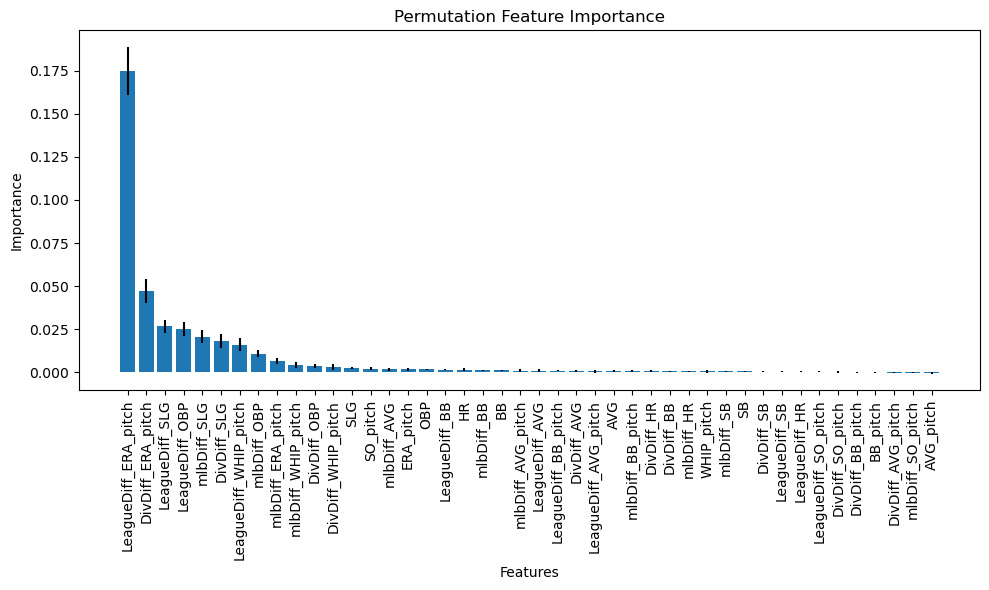

In [9]:
rf=randomForrests(data,base_features)
print('Baseline Random Forest RMSE',rf.getError())
feature_importance=do_permutation_feature_importance(rf.model,rf.X_test,rf.y_test)

**Summary of Feature Importance for MLB Win Prediction Model:**

The permutation feature importance analysis reveals that **pitching statistics, particularly ERA (Earned Run Average), are the most significant predictors of team wins**. The team's ERA relative to its league (`LeagueDiff_ERA_pitch`) shows the strongest influence, followed by ERA relative to the division (`DivDiff_ERA_pitch`). This indicates that a team's pitching performance compared to its direct competitors is crucial in determining its success.

Among hitting statistics, **slugging percentage (SLG) and on-base percentage (OBP)** relative to the league (`LeagueDiff_SLG`, `LeagueDiff_OBP`) are the most influential factors. This highlights the importance of power hitting and getting on base for scoring runs and winning games.

**Key Findings:**

* **Pitching Dominance:** ERA, especially when compared to league and division averages, is the strongest predictor of team wins.
* **Hitting Impact:** SLG and OBP relative to the league are the most important hitting statistics.
* **Relative Performance:** Statistics representing a team's performance relative to its league, division, and the entire MLB are more influential than raw statistics.
* **Other Notable Features:** Strikeouts by pitchers (`SO_pitch`) and stolen bases (`SB`) also have a noticeable impact.

**Implications:**

* Teams with significantly better pitching performance than their league and division rivals are likely to win more games.
* Offensive production, as measured by SLG and OBP, significantly contributes to team success.
* The model prioritizes relative performance over raw performance, suggesting that outperforming your direct competition is key.

This summary provides a clear and concise overview of the key insights derived from the permutation feature importance analysis.

# Baseline XgBoost Model

In [12]:
# Create a list of features to use in the model, including base features and relative difference features.
features = base_features + ['DivDiff_' + item for item in base_features] + \
           ['LeagueDiff_' + item for item in base_features] + \
           ['mlbDiff_' + item for item in base_features]

# Create training and testing data
train, test = tts(data, test_size=0.3, random_state=42)
X_train = train[features]
y_train = train['WINS']
X_test = test[features]
y_test = test['WINS']

# XGB model with default parameters
model = xgb.XGBRegressor(random_state=42)

# Fit and make predictions
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Print R2 and RMSE scores on test set
print('Baseline Scores for XGB model on test set')
print('\tR2: ', r2_score(y_test, y_pred))
print('\tRMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))

# Cross-validation scores
rmse_scores = np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

# Print cross-validation scores
print('\nCross-Validation Scores:')
print('\tRMSE:', rmse_scores)
print('\tMean RMSE:', rmse_scores.mean())
print('\tStd RMSE:', rmse_scores.std())
print('\tR2:', r2_scores)
print('\tMean R2:', r2_scores.mean())
print('\tStd R2:', r2_scores.std())

Baseline Scores for XGB model on test set
	R2:  0.8131107816573429
	RMSE:  5.221262688407245

Cross-Validation Scores:
	RMSE: [5.35390062 5.3572666  5.59649169 5.67528251 5.77772906]
	Mean RMSE: 5.552134097766694
	Std RMSE: 0.17046763176545504
	R2: [0.76666947 0.80256371 0.79012999 0.77555879 0.76156719]
	Mean R2: 0.7792978289178234
	Std R2: 0.01514244431727664


### Hyperparameter Grid Search.

In [14]:
rerun = False  # Set to False to use the saved parameters

if rerun:
    param_grid2 = {
        'n_estimators': [100,200, 300,400],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 1],
        'colsample_bytree': [0.7, 0.8, 1],
        'gamma': [0, 0.01, 0.1, 0.2]
    }
    grid_search2 = GridSearchCV(xgb.XGBRegressor(random_state=42),
                                param_grid=param_grid2, scoring='neg_mean_squared_error')
    CV2 = grid_search2.fit(X_train, y_train)
    print(CV2.best_params_)
else:
    print('**' * 29, 'Best Parameters from Saved Results', '**' * 14)

    try:
        results_df = pd.read_csv('data/grid_search_results.csv')
        # Sort by 'mean_test_score' in descending order
        results_df_sorted = results_df.sort_values(by='mean_test_score', ascending=False)
        # Select the best parameters from the first row of the sorted dataframe.
        best_params_series = results_df_sorted.iloc[0]['params']
        #Convert the string representation of the dictionary into a dictionary.
        import ast
        best_params=ast.literal_eval(best_params_series)

        for key, value in best_params.items():
            print(f'{key}: {value}')

    except FileNotFoundError:
        print("grid_search_results.csv not found. Using default parameters.")
        D = {'colsample_bytree': 0.8,
             'gamma': 0.01,
             'learning_rate': 0.05,
             'max_depth': 3,
             'n_estimators': 300,
             'subsample': 0.7}
        for key, value in D.items():
            print(f'{key}: {value}')
    except KeyError:
        print("grid_search_all_results.csv is malformed. Using default parameters.")
        D = {'colsample_bytree': 0.8,
             'gamma': 0.01,
             'learning_rate': 0.05,
             'max_depth': 3,
             'n_estimators': 300,
             'subsample': 0.7}
        for key, value in D.items():
            print(f'{key}: {value}')

********************************************************** Best Parameters from Saved Results ****************************
colsample_bytree: 0.7
gamma: 0.1
learning_rate: 0.05
max_depth: 4
n_estimators: 200
subsample: 0.7


### Cross validated scores for best model

In [16]:
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import numpy as np

# Assuming you have X_train and y_train defined

# Create an XGBoost regressor with your desired parameters
best_model_xgb = xgb.XGBRegressor(
    colsample_bytree=0.7,
    gamma=0.1,
    learning_rate=0.05,
    max_depth=4,
    n_estimators=200,
    subsample=0.7,
    random_state=42  # For reproducibility
)

# Call cross_val_score for RMSE
rmse_scores = np.sqrt(-cross_val_score(best_model_xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))

# Call cross_val_score for R2
r2_scores = cross_val_score(best_model_xgb, X_train, y_train, cv=5, scoring='r2')

# Print RMSE scores
print("RMSE scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Standard deviation of RMSE:", rmse_scores.std())

# Print R2 scores
print("\nR2 scores:", r2_scores)
print("Mean R2:", r2_scores.mean())
print("Standard deviation of R2:", r2_scores.std())

RMSE scores: [5.23960223 5.04817481 5.03119568 5.00256054 5.03641919]
Mean RMSE: 5.071590489978593
Standard deviation of RMSE: 0.08533478973651414

R2 scores: [0.7765257  0.82468897 0.83038624 0.82561371 0.81882619]
Mean R2: 0.8152081622556093
Standard deviation of R2: 0.019687346567719553


### Best model scores on test set

In [18]:
best_model_xgb.fit(X_train,y_train)
y_pred=best_model_xgb.predict(X_test)
print('R2 (Test Set): ',r2_score(y_test,y_pred))
print('RMSE (Test Set): ', np.sqrt(mean_squared_error(y_test,y_pred)))      

R2 (Test Set):  0.851400171676267
RMSE (Test Set):  4.655781322252208


# Permutation Feature Importance


Permutation Feature Importance:


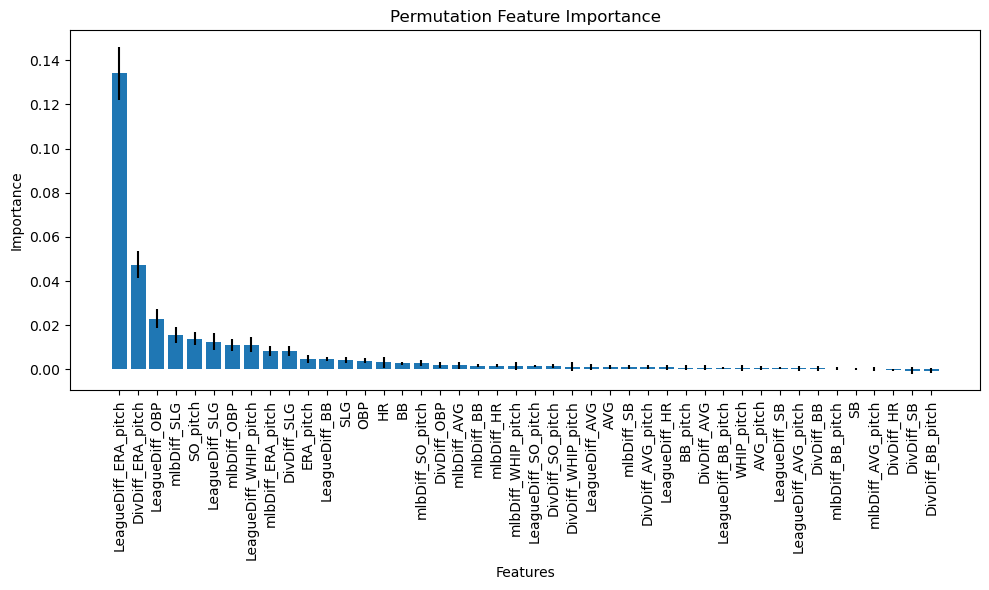

In [20]:
feature_importance=do_permutation_feature_importance(best_model_xgb,X_test,y_test)

### Remove Features that are negatively impacting the model performance

In [22]:
# Create list of important features
keep_features=feature_importance[feature_importance['importance']>0]['feature'].values

# Reset the training and testing data to only include the features in the list
X_train=train[keep_features]
y_train=train['WINS']
X_test=test[keep_features]
y_test=test['WINS']

# Refit model with updated features and make predictions on test set.
best_model_xgb.fit(X_train,y_train)
y_pred=best_model_xgb.predict(X_test)
print('Test R2',r2_score(y_test,y_pred))
print('Test RMSE', np.sqrt(mean_squared_error(y_test,y_pred)))

# Call cross_val_score for RMSE
rmse_scores = np.sqrt(-cross_val_score(best_model_xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))

# Call cross_val_score for R2
r2_scores = cross_val_score(best_model_xgb, X_train, y_train, cv=5, scoring='r2')

# Print RMSE scores
print("\nCross Val RMSE scores:", rmse_scores)
print("Cross Val Mean RMSE:", rmse_scores.mean())
print("Cross Val Standard deviation of RMSE:", rmse_scores.std())

# Print R2 scores
print("\nCross ValR2 scores:", r2_scores)
print("Cross ValMean R2:", r2_scores.mean())
print("Cross Val Standard deviation of R2:", r2_scores.std())

Test R2 0.8439928583493796
Test RMSE 4.770409484232136

Cross Val RMSE scores: [5.09095785 4.87734377 4.95581596 4.87307897 5.09584871]
Cross Val Mean RMSE: 4.978609052810907
Cross Val Standard deviation of RMSE: 0.09826308715302016

Cross ValR2 scores: [0.78902551 0.83635332 0.83543063 0.83452418 0.81452528]
Cross ValMean R2: 0.8219717837694309
Cross Val Standard deviation of R2: 0.01836539895476452


### Save model to disk

In [24]:
import joblib
joblib.dump(best_model_xgb, 'models/best_model_xg.joblib')
np.save('data/best_model_xg_features.npy',keep_features)


# Predicting the 2024 Season

In [26]:
def CorrectWins(df):
    """Returns the amount of wins proportional to the total wins of all teams but in an amount that makes the total
    Amount of wins equal to the expected amount of wins for a season 2430."""
    predicted_total=df['Predicted_Wins'].sum()
    df['Adjusted_Prediction']=round((df['Predicted_Wins']/predicted_total)*(162*30/2))
    return df
# Refit model on all historic data
X=data[keep_features]
y=data['WINS']
best_model_xgb.fit(X,y)

# Read in 2024 aggregated stats created in notebook Create_2024_Team_Stats
df_2024=pd.read_csv('data/2024teamStatsProjections2.csv')

# Create features
df_2024=leagueStats(df_2024,base_features).applyAgg()

# Get predictions
df_2024['Predicted_Wins']=best_model_xgb.predict(df_2024[keep_features])

# Adjust wins to ensure that the total number of wins matches the expected amount of games for a typical 162 game season
df_2024=CorrectWins(df_2024)
df_2024['Prediction']=df_2024['Adjusted_Prediction']

# Print results
playoffPicture(df_2024).Print()

Division NL W
|    | Team   |   Wins |
|---:|:-------|-------:|
| 13 | LAD    |     89 |
| 24 | SFG    |     84 |
| 22 | SDP    |     80 |
|  0 | ARI    |     79 |
|  8 | COL    |     61 |
Division NL E
|    | Team   |   Wins |
|---:|:-------|-------:|
|  1 | ATL    |     95 |
| 20 | PHI    |     90 |
| 18 | NYM    |     83 |
| 29 | WSN    |     73 |
| 14 | MIA    |     68 |
Division NL C
|    | Team   |   Wins |
|---:|:-------|-------:|
|  5 | CHC    |     89 |
|  6 | CIN    |     87 |
| 21 | PIT    |     80 |
| 25 | STL    |     80 |
| 15 | MIL    |     77 |
Division AL W
|    | Team   |   Wins |
|---:|:-------|-------:|
| 10 | HOU    |     87 |
| 23 | SEA    |     83 |
| 12 | LAA    |     80 |
| 27 | TEX    |     80 |
| 19 | OAK    |     68 |
Division AL E
|    | Team   |   Wins |
|---:|:-------|-------:|
| 28 | TOR    |     92 |
| 17 | NYY    |     90 |
|  3 | BOS    |     83 |
|  2 | BAL    |     81 |
| 26 | TBR    |     78 |
Division AL C
|    | Team   |   Wins |
|---:|:-------|-

## Model Performance Summary and Conclusions

This analysis aimed to build a robust model to predict MLB team wins using XGBoost. The process involved establishing a baseline, tuning hyperparameters via grid search, and performing feature selection based on Permutation Feature Importance (PFI).

**Baseline Model Performance:**

The initial XGBoost model, using default parameters, achieved the following scores on the test set:

* **R2 (Test Set):** 0.8131
* **RMSE (Test Set):** 5.2213

Cross-validation on the training data yielded:

* **Mean RMSE (CV):** 5.5521
* **Mean R2 (CV):** 0.7793

These baseline scores provided a benchmark for subsequent improvements.

**Hyperparameter Tuning (Grid Search):**

After conducting grid search, the model's performance improved significantly:

* **Mean RMSE (CV):** 5.0716
* **Mean R2 (CV):** 0.8152
* **R2 (Test Set):** 0.8514
* **RMSE (Test Set):** 4.6558

The grid search effectively optimized the model's hyperparameters, leading to better predictive accuracy and generalization.

**Feature Selection (PFI):**

Feature selection based on Permutation Feature Importance resulted in a slight decrease in test set R2 and a slight increase in test set RMSE compared to the tuned model. However, the cross-validation scores improved.

* **R2 (Test Set):** 0.8440
* **RMSE (Test Set):** 4.7704
* **Mean RMSE (CV):** 4.9786
* **Mean R2 (CV):** 0.8220

The cross validation scores indicate that the model with feature selection may generalize better to unseen data, even though the test scores are slightly worse. Removing features slightly reduced the variance of the cross validation scores.

**Conclusions:**

* Hyperparameter tuning significantly improved the model's performance, demonstrating the importance of optimizing model parameters.
* Feature selection based on PFI resulted in a model with potentially better generalization capabilities, as indicated by improved cross-validation scores, despite a small decrease in test set performance.
* The model has shown to be effective at predicting MLB wins, with R2 scores consistently above 0.8.
* The model has been shown to be robust, as the standard deviation of the cross validation scores are relatively small.

Further analysis could explore additional feature engineering or different model architectures to potentially achieve even better performance.

# 2024 season
- As for the 2024 season, we will have to see how it shakes out.  The predicted standings generally align with what one might expect, however I do notice some suprises.  For example, I would not expect the Brewers to have as bad of a season as predicted.  Furthermore, I would expect the dodgers to produce more than 89 wins.  Some of these discrepancies could possibly be explained by difficulties in the data gathering and preprocessing steps.  Nevertheless, this was an interesting analysis and it reinforces our understanding about what statistics generally produce wins in the MLB.